# Filtering Analysis

The purpose of this [SoS notebook](https://vatlab.github.io/sos-docs/) is to explore filtering options for the main notebook.

The main problems are that many of the clips returned have incorrect alignment and have background noise of some type.

It's possible that we may be able to filter these out using properties of the alignment or properties of the audio.
This would entail building a classifier for clips (good/bad) and then using the classifier to filter clips before any manual correction.

Some data has already been labeled using [the manual annotator I developed](https://olney.ai/category/2019/06/18/manualalignment.html).
The analysis below uses this data.

## Get basic audio features

Using librosa, following [this example](https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8).
Though their are a [variety of more sophisticated approaches](https://www.google.com/search?q=github+classify+music+vs+speech&), I decided to keep things simple for now.

In [58]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

#prepare header
header = 'filename chroma_stft spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header = header.split()

#write features to file
file = open('audioFeatures.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for filename in os.listdir(f'/y/south-park-1-to-20/wavs/'):
    if filename.startswith("Cartman-1-1"):
        filePath = f'/y/south-park-1-to-20/wavs/{filename}'
        y, sr = librosa.load(filePath, mono=True,)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        file = open('audioFeatures.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())


## Merge audio features with alignment data

In [86]:
#r "/z/aolney/repos/Newtonsoft.Json.9.0.1/lib/net40/Newtonsoft.Json.dll"

type TTSDataManual =
    {
        Start : int
        Stop : int
        Text : string
        Id : string
        WavFile : string
        ///is first word aligned
        FrontAligned : bool
        ///is last word aligned
        EndAligned : bool
        ///sum of differences b/w subtitle and alignment timings
        SumAlignmentDiff : int
        ///proportion of words that are aligned
        ProportionAligned : float
        /// numerics to word correction
        ExpandedText : string
        ///Label
        Status : string
    }
    
let labeledDataMap =
    "/y/south-park-1-to-20/manual-alignment/corrected/1-1.manual.json.corrected"
    |> System.IO.File.ReadAllText
    |> Newtonsoft.Json.JsonConvert.DeserializeObject<TTSDataManual[]>
    |> Array.map( fun tts -> tts.Id,tts)
    |> Map.ofArray
    

let mergedData =
    "audioFeatures.csv"
    |> System.IO.File.ReadAllLines
    |> Seq.skip 1 //header
    |> Seq.choose( fun line ->
        let s = line.Split(",")
        let fileName = s.[0].Replace(".wav","")
        match labeledDataMap.TryFind fileName with
        | Some(d) ->
            Some(line.Replace(",","\t") + "\t" + d.Start.ToString() + "\t" +  d.Stop.ToString() + "\t" + d.Text + "\t" + d.Id + "\t" + d.WavFile + "\t" 
                   + d.FrontAligned.ToString() + "\t" + d.EndAligned.ToString() + "\t" + d.SumAlignmentDiff.ToString() + "\t" 
                   + d.ProportionAligned.ToString() + "\t" + d.ExpandedText  + "\t" + d.Status)
        | None -> None
              )
    |> Seq.toList
    
let mutable header = "audioFeatures.csv" |> System.IO.File.ReadAllLines |> Array.head
header <- header.Replace(",","\t") + "\tStart\tStop\tText\tId\tWavFile\tFrontAligned\tEndAligned\tSumAlignmentDiff\tProportionAligned\tExpandedText\tStatus"

System.IO.File.WriteAllLines("filterAnalysisData.tsv", [header] @ mergedData)



## Develop features

In [111]:
# Get required packages
if (!require("pacman"))install.packages("pacman",repos = "https://cloud.r-project.org/")
p_load(jsonlite,readr,rms,glmpath,caret,e1071,dplyr,party,rpart.plot,pROC)

#Load json into dataframe
#json <- read_file("/y/south-park-1-to-20/manual-alignment/corrected/1-1.manual.json.corrected") 
#df <- jsonlite::fromJSON (json) 
df <- read.delim("filterAnalysisData.tsv",quote="", stringsAsFactors=FALSE)

#Construct some features on transcripts
df$Good <- ifelse( df$Status == "good", 1, 0)
df$FrontAligned <- ifelse( df$FrontAligned == "True", 1,0) 
df$EndAligned <- ifelse( df$EndAligned == "True", 1,0) 
df$Good.f <- ifelse( df$Status == "good", "YES", "NO") %>% as.factor
df$FrontAligned.f <- ifelse( df$FrontAligned == 1, "YES", "NO") %>% as.factor
df$EndAligned.f <- ifelse( df$EndAligned == 1, "YES", "NO") %>% as.factor
df$logSAD <- log(df$SumAlignmentDiff)
df$LengthTime <- df$Stop - df$Start
df$LengthChars <- nchar( df$ExpandedText, type="chars" )
df$CharsTime <- df$LengthChars / df$LengthTime
df$logLT <- log(df$LengthTime)
df$logLC <- log(df$LengthChars)

#check basic integrity
str(df)
summary(df)
head(df)

'data.frame':	296 obs. of  47 variables:
 $ filename          : chr  "Cartman-1-1-1135735-1136736.wav" "Cartman-1-1-3521129-3523259.wav" "Cartman-1-1-4621159-4622201.wav" "Cartman-1-1-888910-889230.wav" ...
 $ chroma_stft       : num  0.506 0.329 0.38 0.538 0.282 ...
 $ spectral_centroid : num  2869 2523 3812 2006 2348 ...
 $ spectral_bandwidth: num  1984 1708 1939 1673 1797 ...
 $ rolloff           : num  4990 4383 5789 3530 4365 ...
 $ zero_crossing_rate: num  0.1976 0.1336 0.2968 0.0785 0.1382 ...
 $ mfcc1             : num  -263 -297 -295 -278 -283 ...
 $ mfcc2             : num  96.5 76.1 51.6 117.8 82.5 ...
 $ mfcc3             : num  -65.8 -83.1 -68.6 -83.4 -62.6 ...
 $ mfcc4             : num  76.3 61.9 80.7 60.5 36.4 ...
 $ mfcc5             : num  -37.4 -54.3 -87 -23.3 -57.3 ...
 $ mfcc6             : num  47.88 5.22 31.78 38.52 5.05 ...
 $ mfcc7             : num  -25.13 -39.39 -49.94 -8.23 -27.17 ...
 $ mfcc8             : num  21.24 -4.78 12.99 18.06 6.62 ...
 $ mfcc9     

   filename          chroma_stft     spectral_centroid spectral_bandwidth
 Length:296         Min.   :0.2231   Min.   :1307      Min.   :1470      
 Class :character   1st Qu.:0.3713   1st Qu.:2488      1st Qu.:1704      
 Mode  :character   Median :0.4108   Median :2841      Median :1786      
                    Mean   :0.4188   Mean   :2808      Mean   :1804      
                    3rd Qu.:0.4606   3rd Qu.:3097      3rd Qu.:1885      
                    Max.   :0.7210   Max.   :4311      Max.   :2572      
    rolloff     zero_crossing_rate     mfcc1            mfcc2       
 Min.   :2636   Min.   :0.02783    Min.   :-573.9   Min.   :-11.96  
 1st Qu.:4411   1st Qu.:0.14625    1st Qu.:-346.9   1st Qu.: 67.68  
 Median :4740   Median :0.18771    Median :-312.5   Median : 80.47  
 Mean   :4727   Mean   :0.18336    Mean   :-316.4   Mean   : 83.92  
 3rd Qu.:5108   3rd Qu.:0.22060    3rd Qu.:-286.6   3rd Qu.: 98.79  
 Max.   :6158   Max.   :0.30836    Max.   :-172.9   Max.   :167.92  

filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,⋯,Good,Good.f,FrontAligned.f,EndAligned.f,logSAD,LengthTime,LengthChars,CharsTime,logLT,logLC
Cartman-1-1-1135735-1136736.wav,0.5063955,2869.169,1984.138,4989.586,0.19758745,-263.2704,96.48345,-65.79101,76.28753,⋯,0,NO,NO,NO,14.636378,1001,15,0.01498501,6.908755,2.708050
Cartman-1-1-3521129-3523259.wav,0.3294389,2522.832,1707.702,4383.060,0.13361923,-297.0069,76.13839,-83.12380,61.91613,⋯,1,YES,NO,YES,15.074329,1780,33,0.01853933,7.484369,3.496508
Cartman-1-1-4621159-4622201.wav,0.3796489,3811.987,1939.015,5789.082,0.29676649,-294.9476,51.55431,-68.57947,80.65369,⋯,1,YES,YES,NO,7.237778,1232,19,0.01542208,7.116394,2.944439
Cartman-1-1-888910-889230.wav,0.5383971,2006.296,1672.537,3529.907,0.07847377,-277.8761,117.75081,-83.41493,60.53365,⋯,0,NO,YES,YES,6.523562,250,3,0.01200000,5.521461,1.098612
Cartman-1-1-3469410-3473081.wav,0.2821239,2348.167,1797.088,4365.078,0.13817131,-282.6698,82.51355,-62.60165,36.43810,⋯,0,NO,YES,NO,15.060937,3671,59,0.01607192,8.208219,4.077537
Cartman-1-1-3523131-3524220.wav,0.3211068,2323.600,1701.664,4194.622,0.11494348,-287.8128,77.97013,-76.19585,42.17165,⋯,1,YES,NO,YES,15.074886,859,17,0.01979045,6.755769,2.833213


## Explore

Let's look at some means for good/bad cases.

It would be nice if proportion alignment made good more likely, so let's look at that too.

In [112]:
"----Descriptives for good/bad cases----"
    df %>% 
    #mutate( AlignedGroups = cut(ProportionAligned, breaks = seq(0,1,.1),include.lowest=TRUE) ) %>%
    group_by(Good) %>%
    summarize(
        meanAligned = mean(ProportionAligned),
        meanFront = mean(as.integer(FrontAligned)), 
        meanEnd = mean(as.integer(EndAligned)), 
        meanSAD = mean(SumAlignmentDiff),
        meanTime = mean(LengthTime),
        meanChar = mean(LengthChars),
        meanCharTime = mean(CharsTime),
        meanChroma = mean(chroma_stft),
        meanCentroid = mean(spectral_centroid),
        meanBandwidth = mean(spectral_bandwidth),
        meanRolloff = mean(rolloff) ,
        meanZero = mean(zero_crossing_rate),
        meanMfcc = mean(mfcc1), #just choose one for display
        n = n() )

"----Descriptives for increasing proportion alignment----"
    df %>% 
    mutate( AlignedGroups = cut(ProportionAligned, breaks = seq(0,1,.1),include.lowest=TRUE) ) %>%
    group_by(AlignedGroups) %>%
    summarize( 
        meanGood = mean(Good), 
       # meanAligned = mean(ProportionAligned),
        meanFront = mean(as.integer(FrontAligned)), 
        meanEnd = mean(as.integer(EndAligned)), 
        meanSAD = mean(SumAlignmentDiff),
        meanTime = mean(LengthTime),
        meanChar = mean(LengthChars),
        meanCharTime = mean(CharsTime),
                meanChroma = mean(chroma_stft),
        meanCentroid = mean(spectral_centroid),
        meanBandwidth = mean(spectral_bandwidth),
        meanRolloff = mean(rolloff) ,
        meanZero = mean(zero_crossing_rate),
        meanMfcc = mean(mfcc1), #just choose one for display
        goodN = sum(Good),
        n = n() )
    

[1] "----Descriptives for good/bad cases----"

Good,meanAligned,meanFront,meanEnd,meanSAD,meanTime,meanChar,meanCharTime,meanChroma,meanCentroid,meanBandwidth,meanRolloff,meanZero,meanMfcc,n
0,0.5085616,0.5500000,0.4437500,2337928,2179.319,29.48125,0.02065192,0.4205343,2704.723,1819.734,4645.805,0.1721793,-301.6874,160
1,0.6649184,0.7426471,0.5882353,1205496,1508.735,27.21324,0.01802979,0.4166707,2929.614,1785.431,4823.573,0.1965098,-333.7448,136


[1] "----Descriptives for increasing proportion alignment----"

AlignedGroups,meanGood,meanFront,meanEnd,meanSAD,meanTime,meanChar,meanCharTime,meanChroma,meanCentroid,meanBandwidth,meanRolloff,meanZero,meanMfcc,goodN,n
"[0,0.1]",0.3088235,0.0000000,0.0000000,4244303.691,1819.088,25.80882,0.01462670,0.4305440,2728.153,1795.180,4675.561,0.1819646,-311.8426,21,68
"(0.1,0.2]",0.2000000,0.4000000,0.2000000,3790135.000,2253.900,35.10000,0.01682820,0.4444405,2714.197,1910.442,4715.780,0.1614351,-313.8020,2,10
"(0.2,0.3]",0.3333333,0.5000000,0.2500000,2946075.500,3524.250,40.41667,0.01960750,0.3879637,2814.502,1727.958,4607.141,0.1909137,-305.0697,4,12
"(0.3,0.4]",0.3888889,0.3333333,0.2222222,2660919.222,2598.000,34.66667,0.01498837,0.4023163,2856.964,1818.731,4799.187,0.1969306,-337.4811,7,18
"(0.4,0.5]",0.8000000,0.7000000,0.2000000,2458846.900,1790.300,24.90000,0.01704190,0.4506251,2858.841,1812.667,4777.542,0.1916961,-349.8561,8,10
"(0.5,0.6]",0.3636364,0.9090909,0.6363636,844891.727,2886.364,45.18182,0.01906767,0.4086581,2713.909,1758.011,4543.833,0.1876998,-302.4976,4,11
"(0.6,0.7]",0.5925926,0.7407407,0.4814815,1562472.000,2623.000,38.66667,0.02229021,0.4097035,2702.061,1780.575,4633.605,0.1697753,-325.1440,16,27
"(0.7,0.8]",0.4545455,0.9090909,0.4545455,1411851.045,1802.818,29.04545,0.01801364,0.4066937,3064.930,1848.895,5013.779,0.2144109,-318.8368,10,22
"(0.8,0.9]",0.6086957,0.9130435,0.6956522,909257.739,2247.000,39.17391,0.01867642,0.3920110,2731.507,1761.030,4566.182,0.1754294,-314.7393,14,23
"(0.9,1]",0.5263158,1.0000000,0.9894737,2209.716,1123.895,19.71579,0.02400552,0.4242848,2859.761,1816.915,4782.921,0.1803458,-312.8646,50,95


### RESULT

- Good/bad almost balanced
- Slight differences on some variables between good/bad
- Highest level of alignment seems to select for short utterances

Looks like a game of week predictors. 
Let's check a pair plot

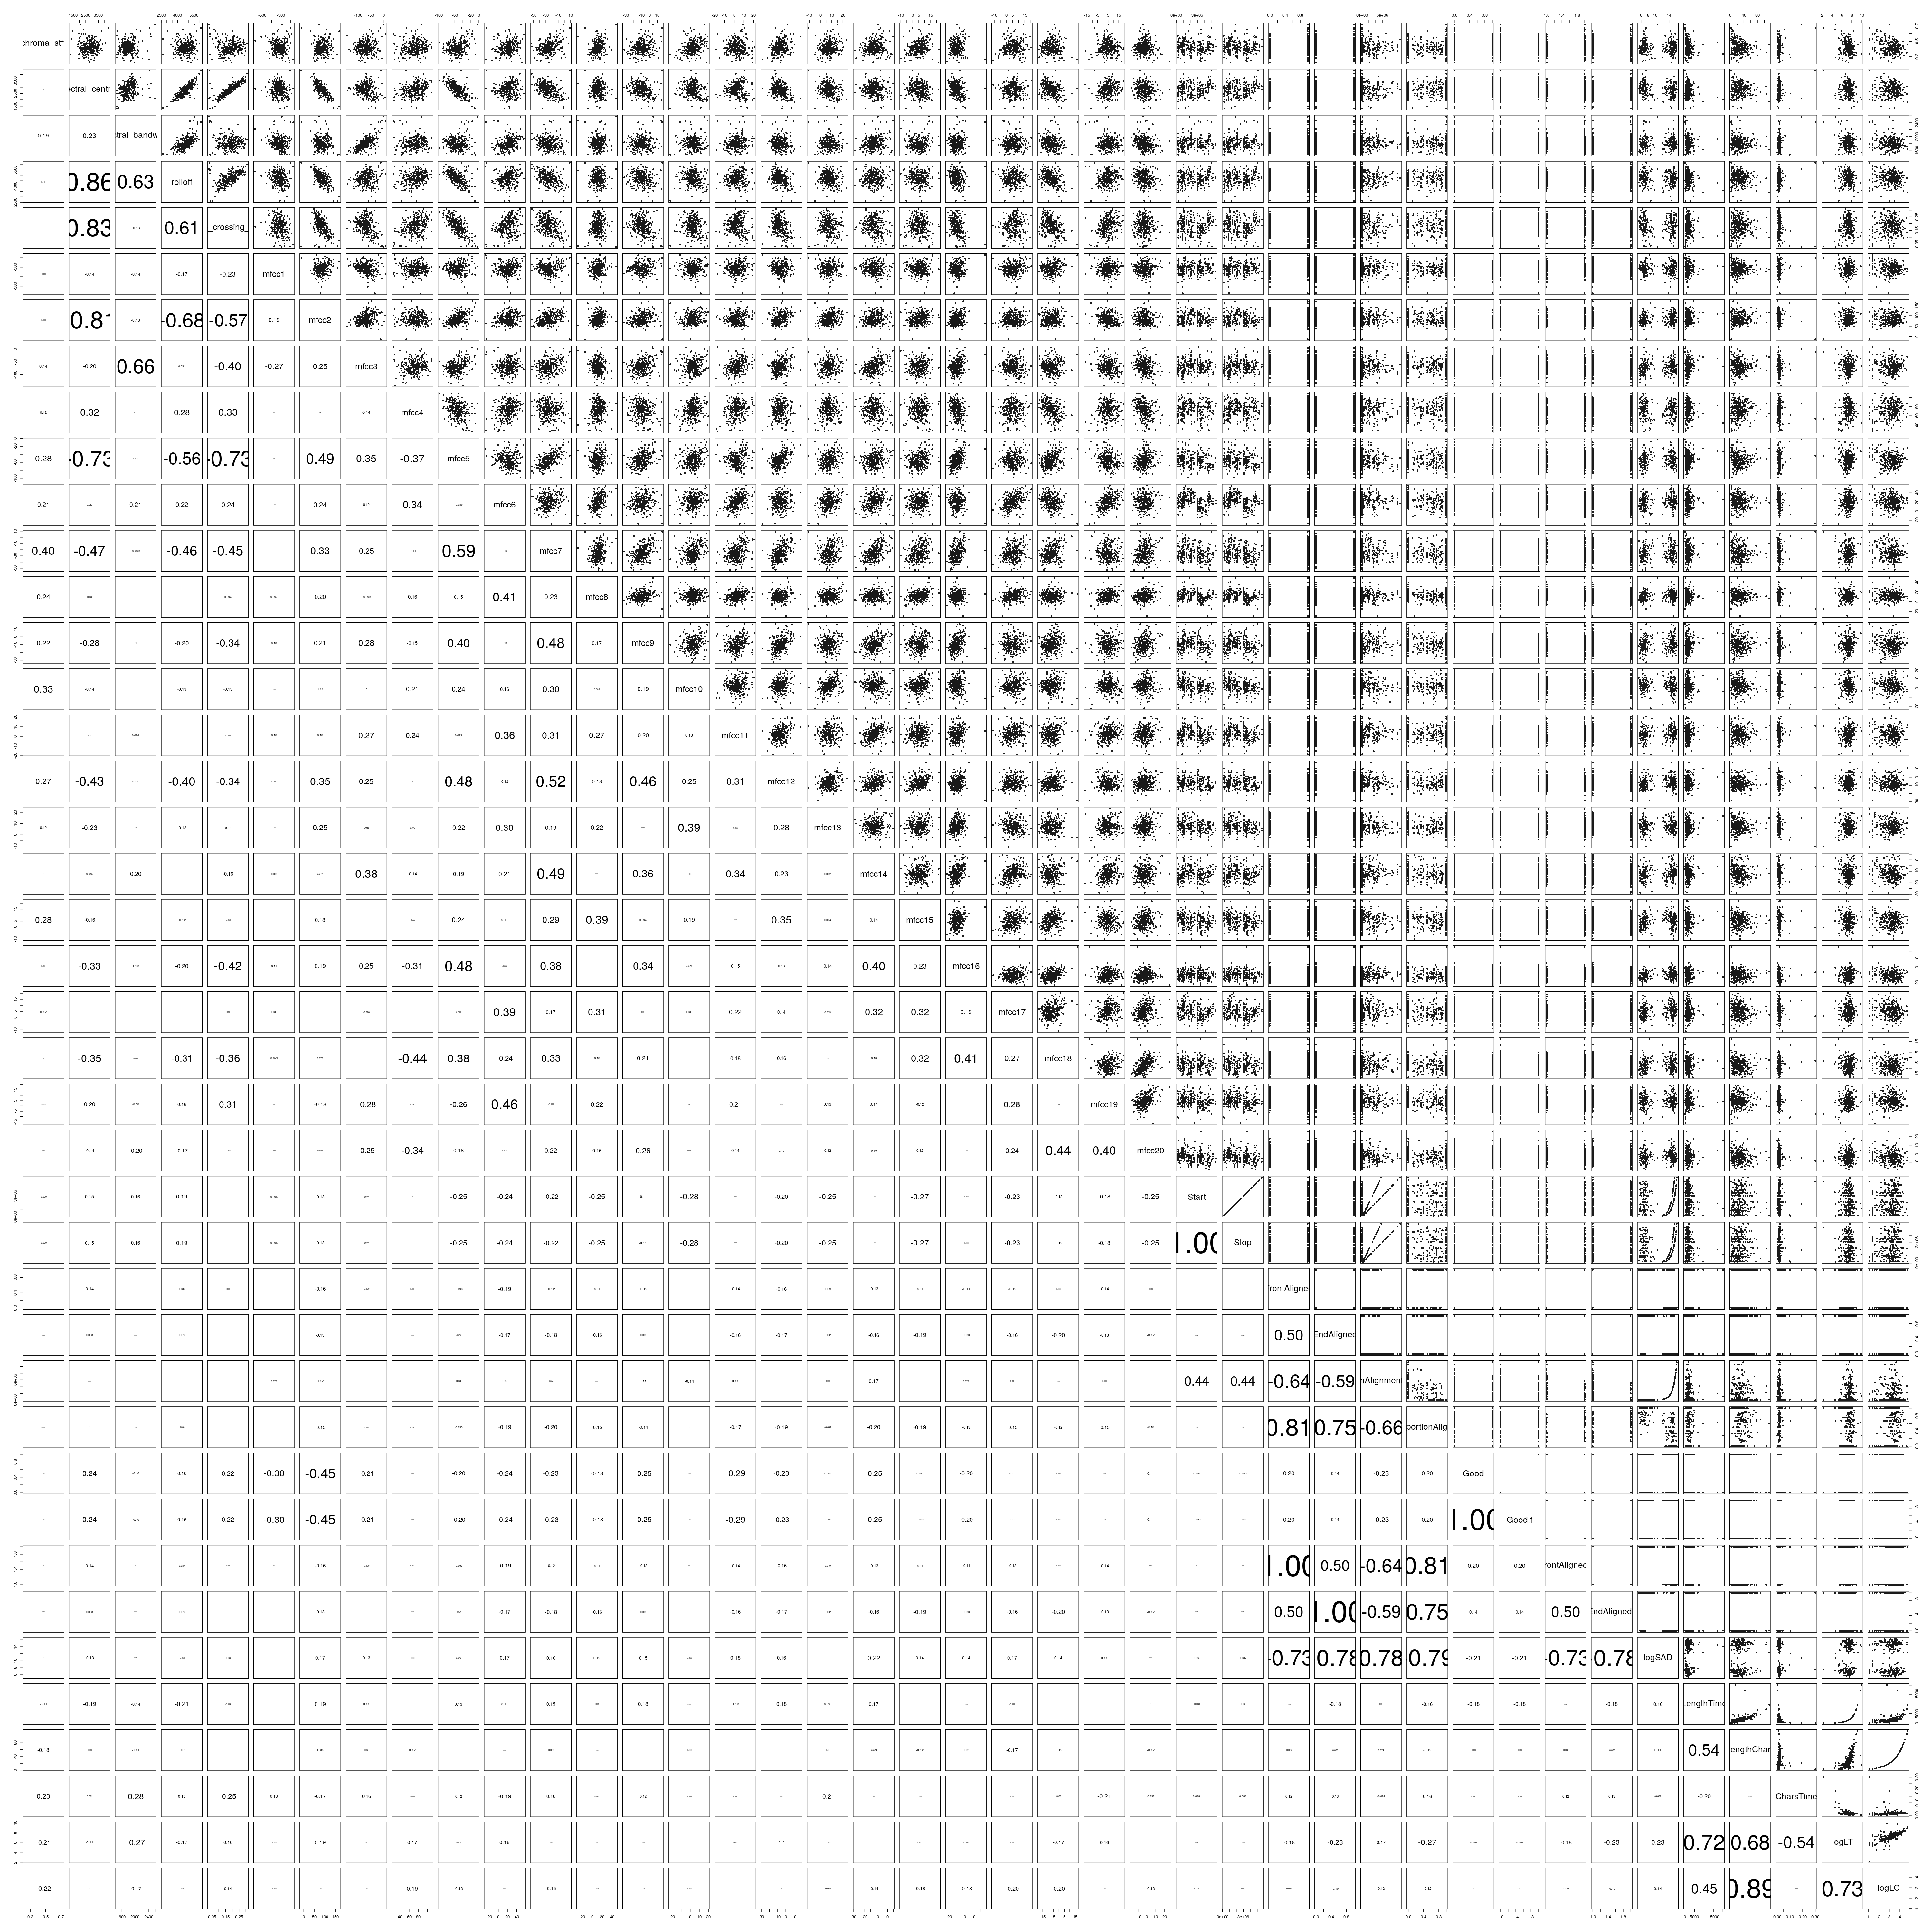

In [113]:
#Really like the pair plot, must remove non numeric vars
df2 <- df[ , !names(df) %in% c("Text","ExpandedText","Id","WavFile","Status","filename")]
source("https://www.highstat.com/Books/Book2/HighstatLibV10.R")
options(repr.plot.width=50, repr.plot.height=50)
Mypairs(df2)
#pairs(df2, lower.panel = panel.smooth2, upper.panel = panel.cor, diag.panel = panel.hist)


### RESULT

- Any alignment-oriented variable is highly correlated with others in that group
- Audio features are pretty highly correlated with each other
- Good has many correlations with audio features, and a strong one with mfcc2
- Very much looks like a game of week predictors.

## Model

### lasso

CV Fold 1 
CV Fold 2 
CV Fold 3 
CV Fold 4 
CV Fold 5 
CV Fold 6 
CV Fold 7 
CV Fold 8 
CV Fold 9 
CV Fold 10 


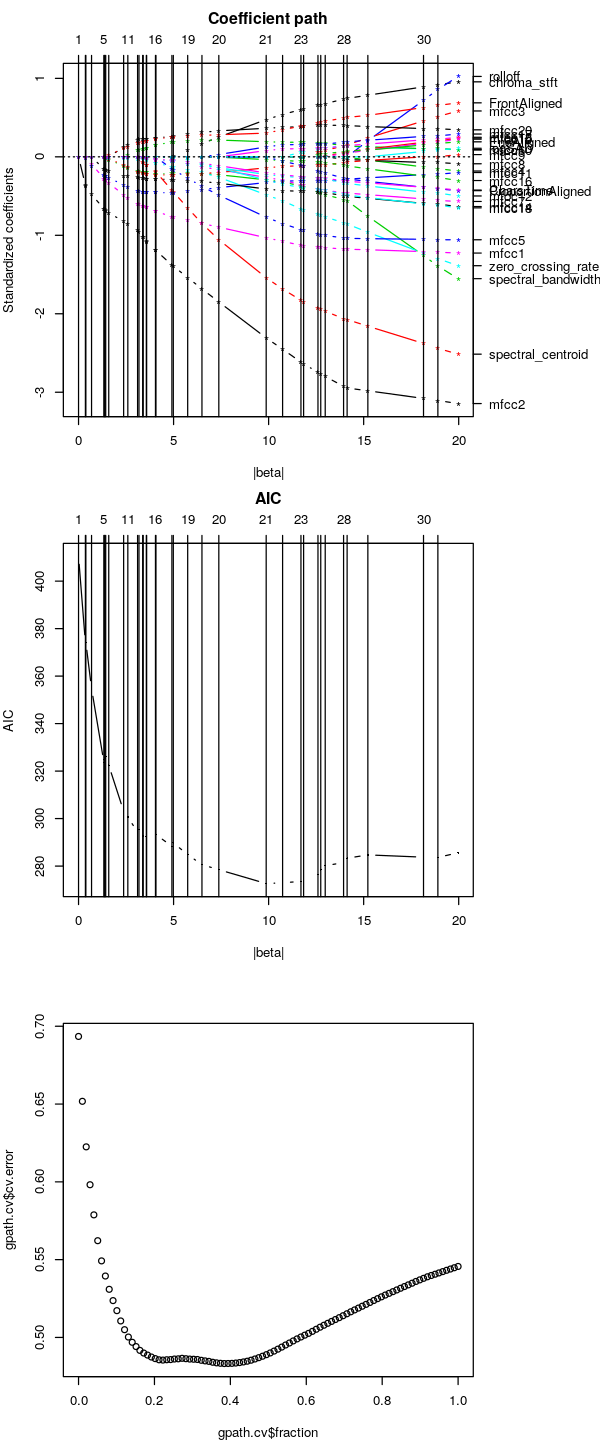

In [125]:
#SumAlignmentDiff creates singular problems without log
# V1, use all
#g2 <- rms::lrm( Good ~  FrontAligned + EndAligned + ProportionAligned + logSAD + logLT + logLC + CharsTime, data = df,  x = TRUE, y = TRUE) 
# V2 exclude  colinearish alignment vars, LengthChars, and LengthTime
#g2 <- rms::lrm( Good ~ ProportionAligned + CharsTime, data = df,  x = TRUE, y = TRUE) 
#with audio
df2 <- df[ , !(names(df)) %in% c("Text","ExpandedText","Id","WavFile","Status","filename",
            "Good.f","FrontAligned.f","EndAligned.f", #duplicates
            "LengthChars","LengthTime","SumAlignmentDiff","Stop","Start","logLC","logLT" #singular warning
                                )]
g2 <- rms::lrm( Good ~ ., data = df2,  x = TRUE, y = TRUE) 

#Seems that proportion aligned by itself is pretty good
#g2 <- rms::lrm( Good ~  ProportionAligned, data = df,  x = TRUE, y = TRUE) 
   

## model matrix x, and outcome vector y
dat.glmpath <- list(x = g2$x, y = g2$y)

## Fit logistic models over a range of L1
gpath <- glmpath(data = dat.glmpath, family = binomial, standardize=TRUE)

#cv
gpath.cv <- cv.glmpath(data = dat.glmpath, family = binomial, standardize=TRUE, plot.it=FALSE)
          
#plot aic and cv
options(repr.plot.width=5, repr.plot.height=12)
op <- par(mfrow=c(3,1),mar = c(4, 4, 4, 8))
plot(gpath, xvar = c("norm", "lambda", "step")[1], type = c("coefficients", "aic", "bic")[1]) # coefficients
plot(gpath, xvar = c("norm", "lambda", "step")[1],type = c("coefficients", "aic", "bic")[2]) # AIC
plot(gpath.cv$fraction,gpath.cv$cv.error) # CV
par(op)

In [126]:
"----summary gpath----"
summary(gpath)
          
"----coefficients with best aic----"
## Show coefficients with the smallest AIC
b.pred.aic <- cbind(gpath$b.predictor, aic = gpath$aic, lambda = gpath$lambda)
best.lasso.coef <- b.pred.aic[which.min(gpath$aic), , drop = FALSE]
blc <- as.data.frame(t(best.lasso.coef))
colnames(blc) <- c("logodds")
names = colnames(best.lasso.coef)
blc <- cbind(names,blc)
blc <- blc[!blc$names=="aic" & !blc$names=="lambda", ]
cbind( blc, oddsratio=exp(blc$logodds))

"----prediction with best aic----"
best.lambda <- as.data.frame( b.pred.aic[which.min(gpath$aic), , drop = FALSE] )$lambda
gpred <- as.integer( predict(gpath,newx = g2$x,s=best.lambda,mode="lambda") > 0 )
g.table <- table( gpred, df$Good,dnn=list("predicted","observed")  ) 
g.table

data.frame( 
    measures=c("precision","recall","fmeasure"), 
    scores=c(
    precision(g.table),
    recall(g.table),
    F_meas(g.table)
    ) )



"----prediction with best cv----"
best.cv.norm.fraction <- gpath.cv$fraction[which.min(gpath.cv$cv.error)]
gpred.cv <- as.integer( predict(gpath,newx = g2$x,s=best.cv.norm.fraction,mode="norm.fraction") > 0 )
g.cv.table <- table( gpred.cv, df$Good,dnn=list("predicted","observed")  ) 
g.cv.table

data.frame( 
    measures=c("precision","recall","fmeasure"), 
    scores=c(
    precision(g.cv.table),
recall(g.cv.table),
F_meas(g.cv.table)
    ) )



[1] "----summary gpath----"

Call:
glmpath(data = dat.glmpath, family = binomial, standardize = TRUE)


,Df,Deviance,AIC,BIC
Step 1,1,408.3950,410.3950,414.0854
Step 2,2,370.1014,374.1014,381.4821
Step 3,3,368.1856,374.1856,385.2567
Step 4,4,346.7806,354.7806,369.5420
Step 5,5,313.6583,323.6583,342.1101
Step 6,6,312.9166,324.9166,347.0588
Step 8,7,311.4527,325.4527,351.2853
Step 9,8,310.1092,326.1092,355.6321
Step 11,9,304.4624,322.4624,355.6756
Step 14,10,283.1069,303.1069,340.0105


[1] "----coefficients with best aic----"

,names,logodds,oddsratio
Intercept,Intercept,7.747563087,2.315922e+03
chroma_stft,chroma_stft,5.896380719,3.637187e+02
spectral_centroid,spectral_centroid,-0.003226024,9.967792e-01
spectral_bandwidth,spectral_bandwidth,-0.001699796,9.983016e-01
rolloff,rolloff,0.000000000,1.000000e+00
zero_crossing_rate,zero_crossing_rate,-8.141054457,2.913298e-04
mfcc1,mfcc1,-0.019238595,9.809453e-01
mfcc2,mfcc2,-0.097110869,9.074554e-01
mfcc3,mfcc3,0.000000000,1.000000e+00
mfcc4,mfcc4,0.000000000,1.000000e+00


[1] "----prediction with best aic----"

         observed
predicted   0   1
        0 130  24
        1  30 112

measures,scores
precision,0.8441558
recall,0.8125000
fmeasure,0.8280255


[1] "----prediction with best cv----"

         observed
predicted   0   1
        0 128  22
        1  32 114

measures,scores
precision,0.8533333
recall,0.8000000
fmeasure,0.8258065


### RESULT

The aic version accuracy is pretty good, f=.82
```
         observed
predicted   0   1
        0 130  24
        1  30 112
```
The features left in the model seem reasonable

### Logistic Regression (using lasso variables) and Decision Tree

In [133]:
fitControl <- trainControl(## 10-fold CV
  method = "repeatedcv",
  number = 10,
    repeats = 10,
  savePredictions = TRUE,
    classProbs = T, summary = twoClassSummary
)

#Required by caret
df2$Good.f <- factor(df2$Good)
levels(df2$Good.f) <- c("Bad","Good")

#Do a train/test split
trainIndex <- createDataPartition(df2$Good.f, p = .7, list = FALSE, times = 1)
dtrain<-df2[trainIndex,]
dtest<-df2[-trainIndex,]

## Logistic regression
#lreg<-train(Good.f ~  FrontAligned + EndAligned + ProportionAligned + logSAD + logLT + logLC + CharsTime,
lreg<-train(Good.f ~  chroma_stft + spectral_centroid + spectral_bandwidth + zero_crossing_rate + mfcc1 + mfcc2 + mfcc5 + mfcc9 + mfcc10 + mfcc11 + mfcc12 + mfcc13 + mfcc14 + mfcc16 + mfcc17 + mfcc18 + mfcc20 + FrontAligned + CharsTime , 
            data = dtrain,
            method="glm",family=binomial(),
            trControl=fitControl )
confusionMatrix( 
    predict(lreg,dtest),
    dtest$Good.f,
    mode="prec_recall")

## decision tree 
#dtree<-train(Good.f ~  FrontAligned + EndAligned + ProportionAligned + logSAD + logLT + logLC + CharsTime,
dtree<-train(Good.f ~  chroma_stft + spectral_centroid + spectral_bandwidth + zero_crossing_rate + mfcc1 + mfcc2 + mfcc5 + mfcc9 + mfcc10 + mfcc11 + mfcc12 + mfcc13 + mfcc14 + mfcc16 + mfcc17 + mfcc18 + mfcc20 + FrontAligned + CharsTime , 
             data=dtrain,
             method="ctree", trControl=fitControl)
confusionMatrix( 
    predict(dtree,dtest), 
    dtest$Good.f,
    mode="prec_recall")

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


Confusion Matrix and Statistics

          Reference
Prediction Bad Good
      Bad   39   10
      Good   9   30
                                          
               Accuracy : 0.7841          
                 95% CI : (0.6835, 0.8647)
    No Information Rate : 0.5455          
    P-Value [Acc > NIR] : 2.788e-06       
                                          
                  Kappa : 0.5637          
                                          
 Mcnemar's Test P-Value : 1               
                                          
              Precision : 0.7959          
                 Recall : 0.8125          
                     F1 : 0.8041          
             Prevalence : 0.5455          
         Detection Rate : 0.4432          
   Detection Prevalence : 0.5568          
      Balanced Accuracy : 0.7812          
                                          
       'Positive' Class : Bad             
                                          

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


Confusion Matrix and Statistics

          Reference
Prediction Bad Good
      Bad   35   11
      Good  13   29
                                          
               Accuracy : 0.7273          
                 95% CI : (0.6219, 0.8168)
    No Information Rate : 0.5455          
    P-Value [Acc > NIR] : 0.0003529       
                                          
                  Kappa : 0.4523          
                                          
 Mcnemar's Test P-Value : 0.8382565       
                                          
              Precision : 0.7609          
                 Recall : 0.7292          
                     F1 : 0.7447          
             Prevalence : 0.5455          
         Detection Rate : 0.3977          
   Detection Prevalence : 0.5227          
      Balanced Accuracy : 0.7271          
                                          
       'Positive' Class : Bad             
                                          

### RESULT

- LR with lasso variables is staying in the f=.75 to .85 range
- DT with lasso variables is about the same or lower, f=.7 to .75

### Set the threshold to avoid false negatives

Use ROC. The caret CV w/repeats gives us a lot of data to make a curve.

Setting levels: control = Bad, case = Good
Setting direction: controls < cases


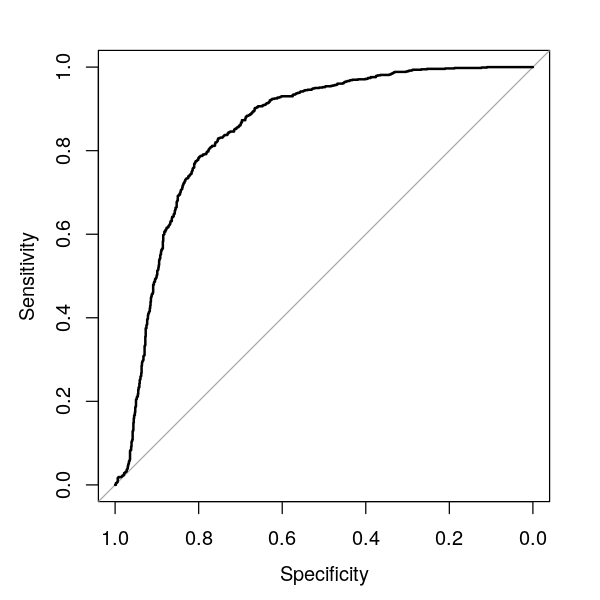

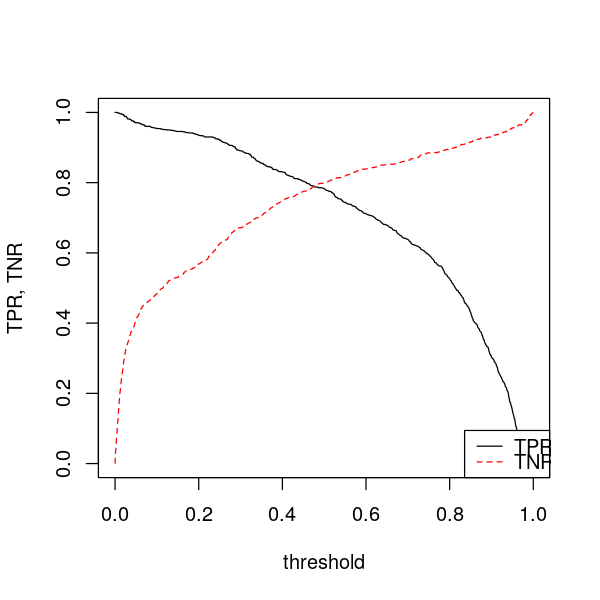

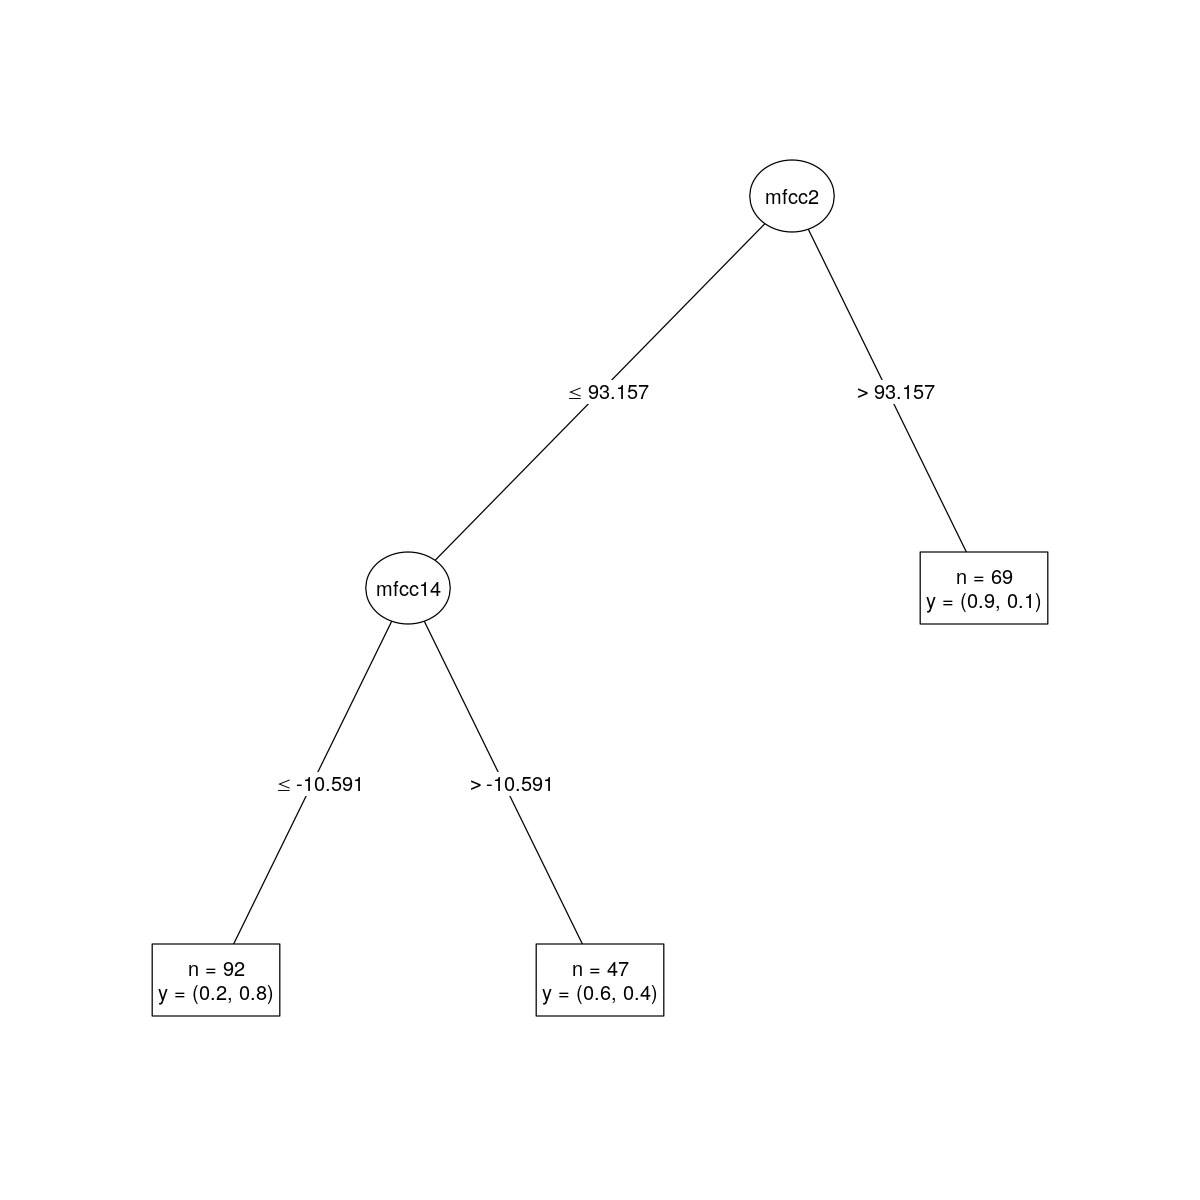

In [134]:
#plot threshold options for logistic regression
#Can't figure out the calls to roc; they seem insane
#update, maybe this link: https://stats.stackexchange.com/questions/133320/logistic-regression-class-probabilities
#myRoc <- roc(predictor = as.ordered(lreg$pred$pred), response = as.ordered(lreg$pred$obs), positive = '1')
#plot(myRoc)
options(repr.plot.width=5, repr.plot.height=5)
#this call makes sense
t <- plot.roc(lreg$pred$obs,lreg$pred$Good)

matplot(data.frame(t$sensitivities, t$specificities), x = t$thresholds, type='l', xlab = 'threshold', ylab='TPR, TNR')
legend('bottomright', legend=c('TPR', 'TNR'), lty=1:2, col=1:2)

options(repr.plot.width=10, repr.plot.height=10)
plot(dtree$finalModel,type="simple",
      inner_panel=node_inner(dtree$finalModel,
      #abbreviate = TRUE,            # short variable names
      pval = FALSE,                 # no p-values
      id = FALSE),                  # no id of node
 terminal_panel=node_terminal(dtree$finalModel, 
      abbreviate = TRUE,
      digits = 1,                   # few digits on numbers
      fill = c("white"),            # make box white not grey
      id = FALSE)
  )

In [135]:
#lasso cv version prediction
gpred.cv <- as.integer( predict(gpath,newx = g2$x,s=best.cv.norm.fraction,mode="norm.fraction",type="response") > .2)
g.cv.table <- table( gpred.cv, df$Good,dnn=list("predicted","observed") ) 
g.cv.table

data.frame( 
    measures=c("precision","recall","fmeasure"), 
    scores=c(
    precision(g.cv.table),
recall(g.cv.table),
F_meas(g.cv.table)
    ) )

         observed
predicted   0   1
        0  90   3
        1  70 133

measures,scores
precision,0.9677419
recall,0.5625000
fmeasure,0.7114625


### RESULT

These results are pretty great, assuming we haven't overfit the model (even with CV'd lasso).
Setting the threshold with the ROC to waste as little "good" data as possible, it looks like we can sacrifice 3/136 (2%) of the data we want to keep to avoid coding 90/296 (30%) of the data we don't want.